In [2]:
import pandas as pd
import numpy as np
import laspy
from sklearn.metrics import precision_recall_fscore_support
from pyntcloud import PyntCloud
from scipy.spatial import ConvexHull
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.append('../src')
import helper
import pickle
from tqdm import tqdm

In [3]:
# Set the figure format to support high DPI
%config InlineBackend.figure_format = 'retina'

#### Import and read real point cloud (.las)

In [4]:
# Load the real point cloud
real_pc_path = '/home/Meins/Uni/TUM/SS23/Data Lab/Labelling/Label-Datasets/valid/validation_classified_merge.las'
real_pc = laspy.read(real_pc_path)

LasData
├─ header (LasHeader)
│   ├─ file_signature
│   ├─ file_source_id
│   ├─ global_encoding
│   ├─ ...
│
├─ points (LasPointRecord)
│   ├─ x
│   ├─ y
│   ├─ z
│   ├─ intensity
│   ├─ classification
│   ├─ ...
│
├─ raw_classification (optional)
├─ raw_scan_angle (optional)
├─ gps_time (optional)
├─ ...


In [5]:
# Some quick data information
header_real = real_pc.header
offsets_real = [header_real.x_offset, header_real.y_offset, header_real.z_offset]
print(offsets_real)

# show maximum and minimum x, y, z values (offset substracted)
min_borders_real = header_real.min
max_borders_real = header_real.max
print(min_borders_real - offsets_real)
print(max_borders_real - offsets_real)

[670000.0, 5400000.0, 0.0]
[8043.80273438 3798.9362793   412.77938843]
[8102.40722656 3887.64355469  443.08679199]


In [6]:
class_descriptions = {
    1: 'Road',
    2: 'Ground',
    #3: 'Road Installations',
    6: 'Wall Surface',
    7: 'Roof Surface',
    8: 'Doors',
    9: 'Windows',
    10: 'Building Installations'
}
relevant_classes = list(class_descriptions.keys())

In [7]:
# Extract the relevant classes from the real point cloud
real_points = real_pc.points
real_labels = real_points['classification']
relevant_indices = np.isin(real_labels, relevant_classes)
relevant_points_real = real_points[relevant_indices]
#real_xyz = relevant_points_real[['x', 'y', 'z']]

#### Visualize point cloud

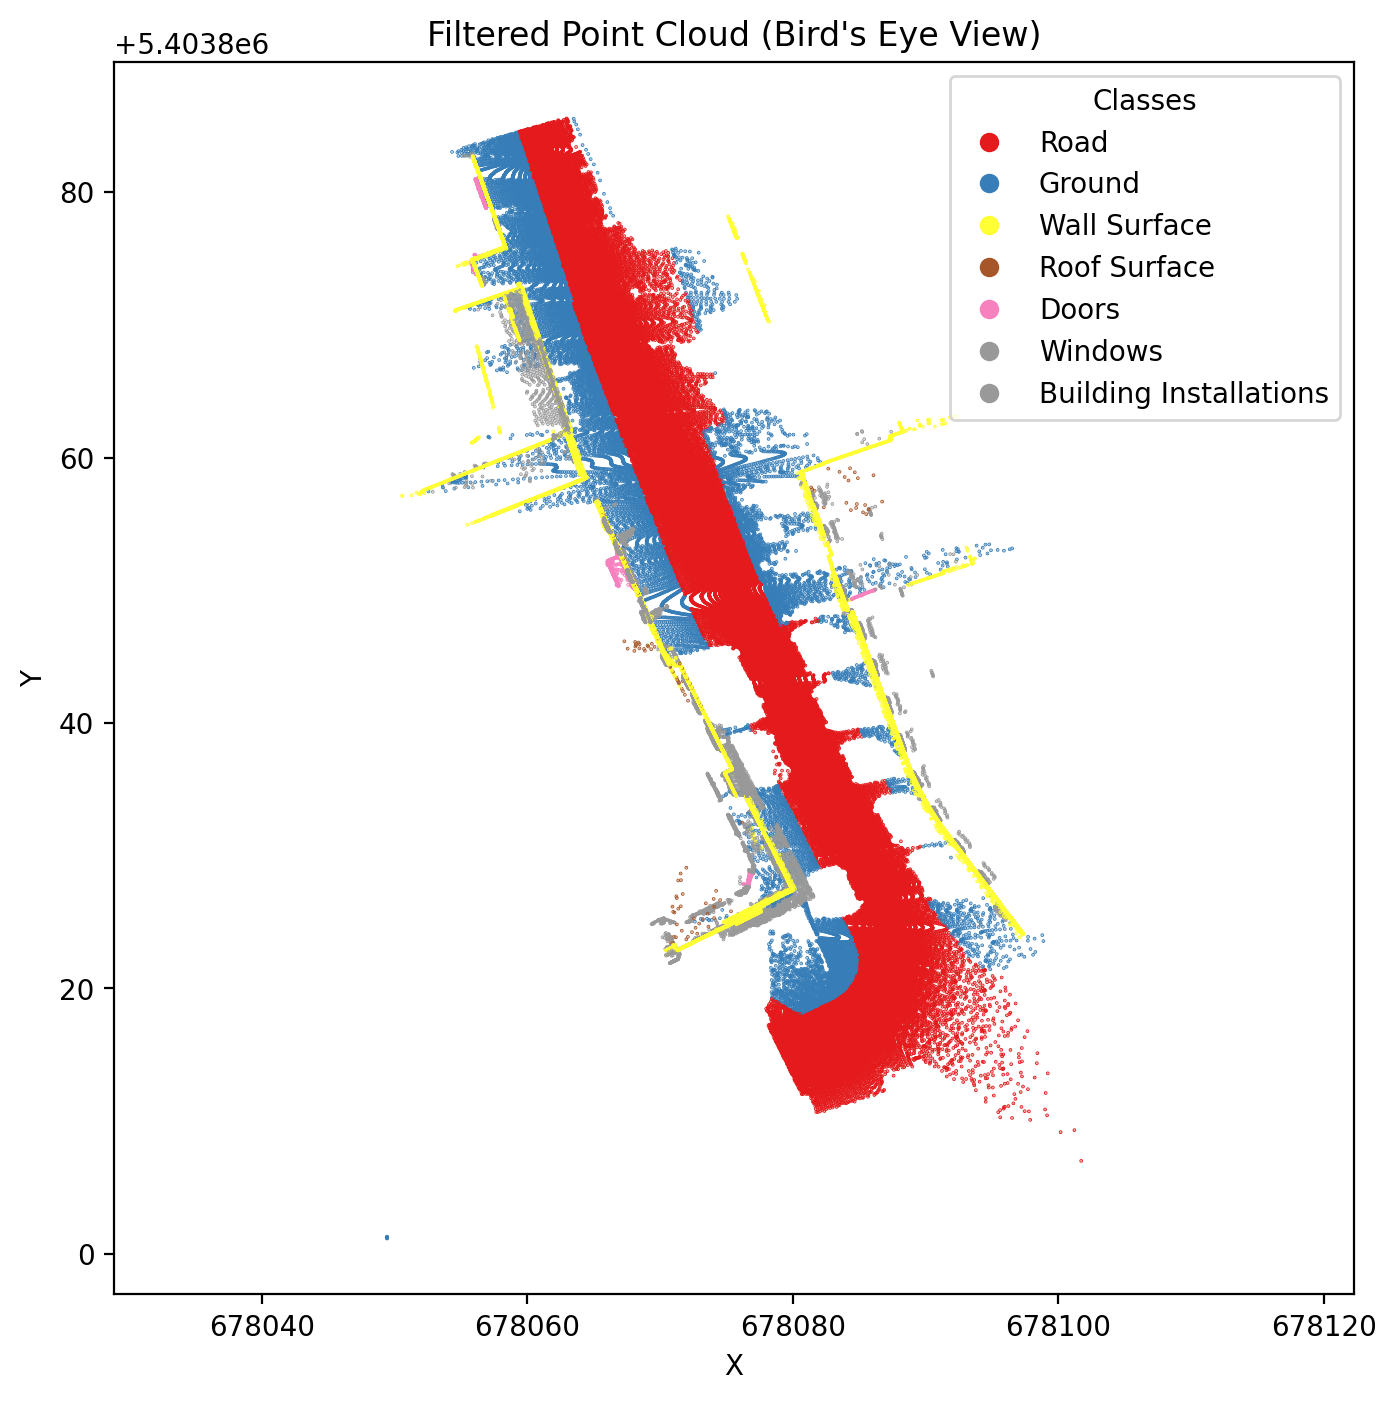

In [8]:
helper.plot_bev(relevant_points_real, class_descriptions)

#### Load Synthetic Point Cloud

In [9]:
# Load the real point cloud
synth_pc_path = '/home/Meins/Uni/TUM/SS23/Data Lab/Labelling/Label-Datasets/valid/validation_classified_merge.las'
synth_pc = laspy.read(synth_pc_path)

In [10]:
# Some quick data information
header_synth = synth_pc.header
offsets_real = [header_synth.x_offset, header_synth.y_offset, header_synth.z_offset]
min_borders_synth = header_synth.min
max_borders_synth = header_synth.max

In [11]:
synth_points = synth_pc.points
synth_labels = synth_points['classification']
relevant_indices_synth = np.isin(synth_labels, relevant_classes)
relevant_points_synth = synth_points[relevant_indices_synth]
#synth_xyz = relevant_points_synth[['x', 'y', 'z']]

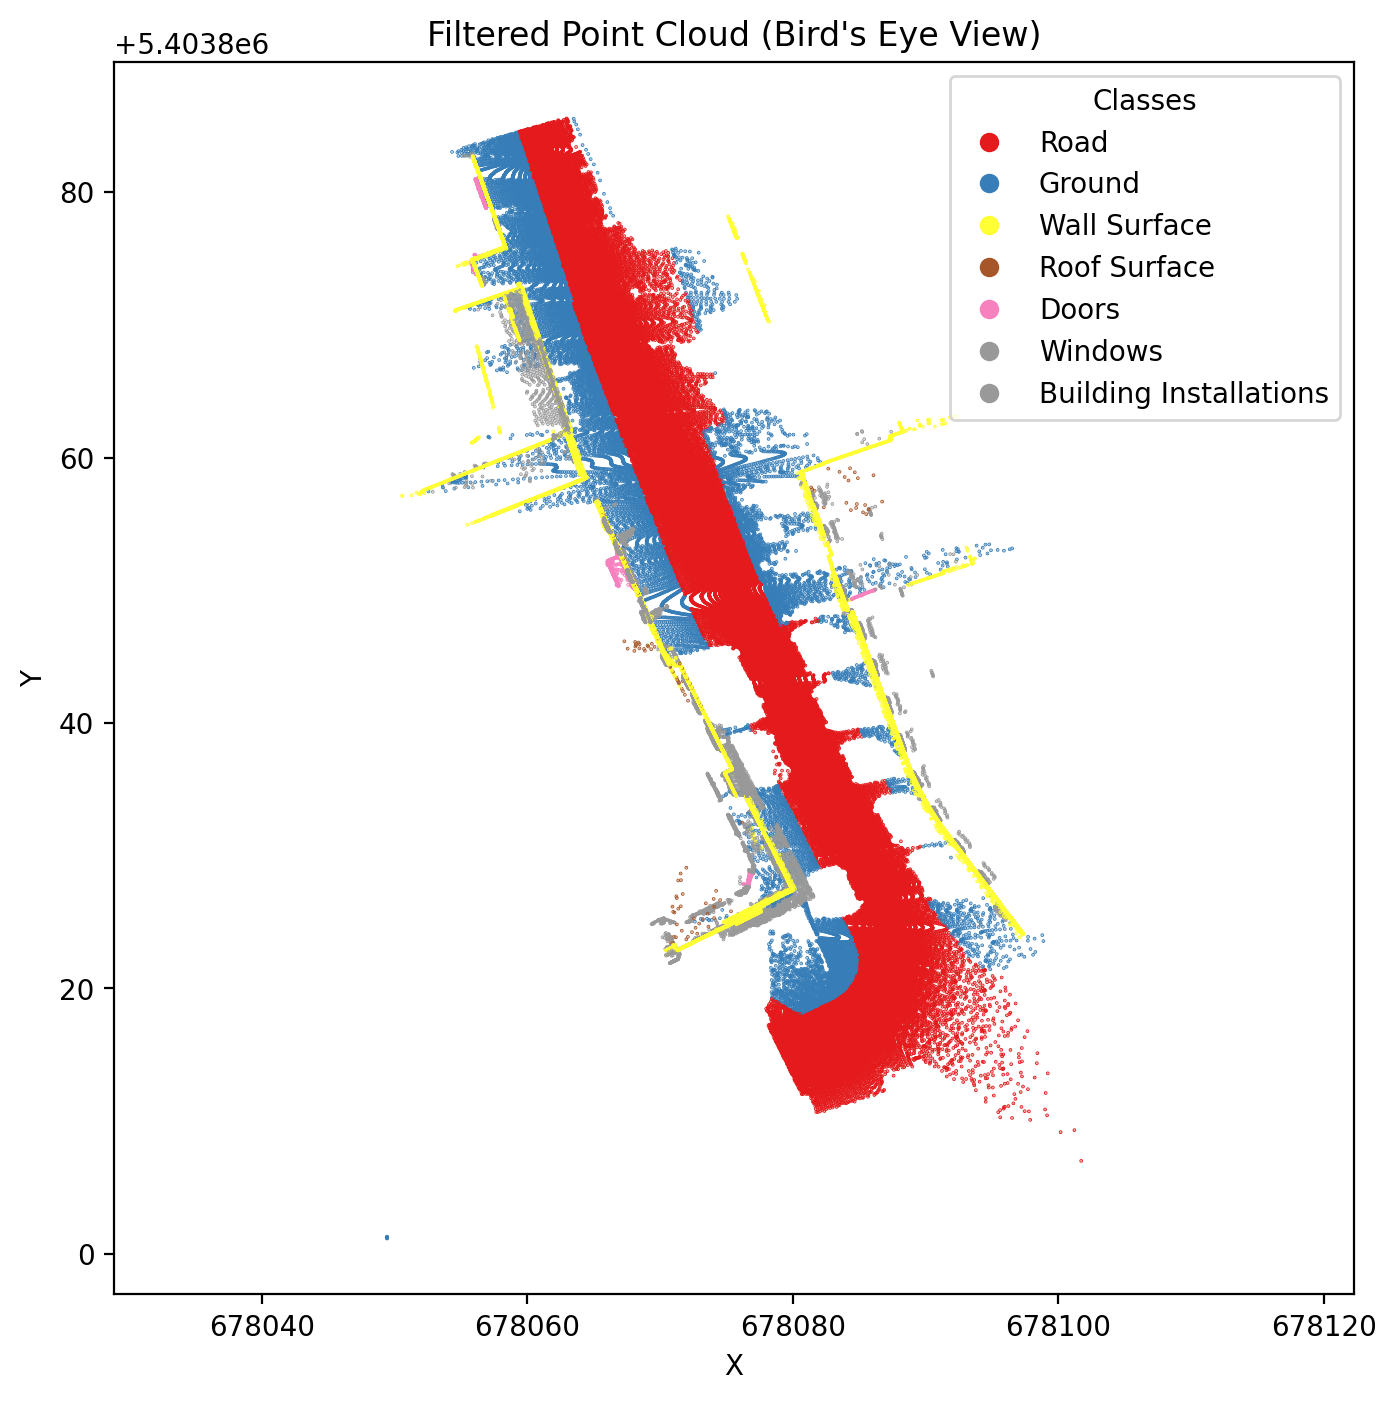

In [12]:
# visualize synthetic point cloud
helper.plot_bev(relevant_points_synth, class_descriptions)

#### Crop Point Clouds (intersection)

In [13]:
# borders constructed by relevent points only (e.g. noise points do not count)
# TODO: this takes ages to compute!
#max_xyz = np.minimum(np.amax(synth_xyz, axis=0), np.amax(real_xyz, axis=0)) # smallest upper bound
#min_xyz = np.maximum(np.amin(synth_xyz, axis=0), np.amin(real_xyz, axis=0)) # greatest lower bound

In [14]:
# TODO: Shift point clouds (use header information). Both point clouds should have the same offset. IS THIS NECESSARY WHEN POINT COORDINATES ARE ABSOLUTE???

In [15]:
padding = 1.0
# TODO: this is bad as we do not filter for our relevant classes beforehand
min_xyz = np.maximum(min_borders_real, min_borders_synth) 
max_xyz = np.minimum(max_borders_real, max_borders_synth)
bounding_box = np.add(np.concatenate((min_xyz, max_xyz)), [-padding, -padding, -padding, padding, padding, padding])
print(bounding_box)

[6.78042803e+05 5.40379794e+06 4.11779388e+02 6.78103407e+05
 5.40388864e+06 4.44086792e+02]


In [16]:
# crops all elements in .points objects (x,y,z, classification, intensity, ...). Header Information is not updated
real_points_cropped = helper.crop_points(relevant_points_real, bounding_box)
synth_points_cropped = helper.crop_points(relevant_points_synth, bounding_box)

In [17]:
# TODO: Use Convex hull for better cropping (intersection of two sets)

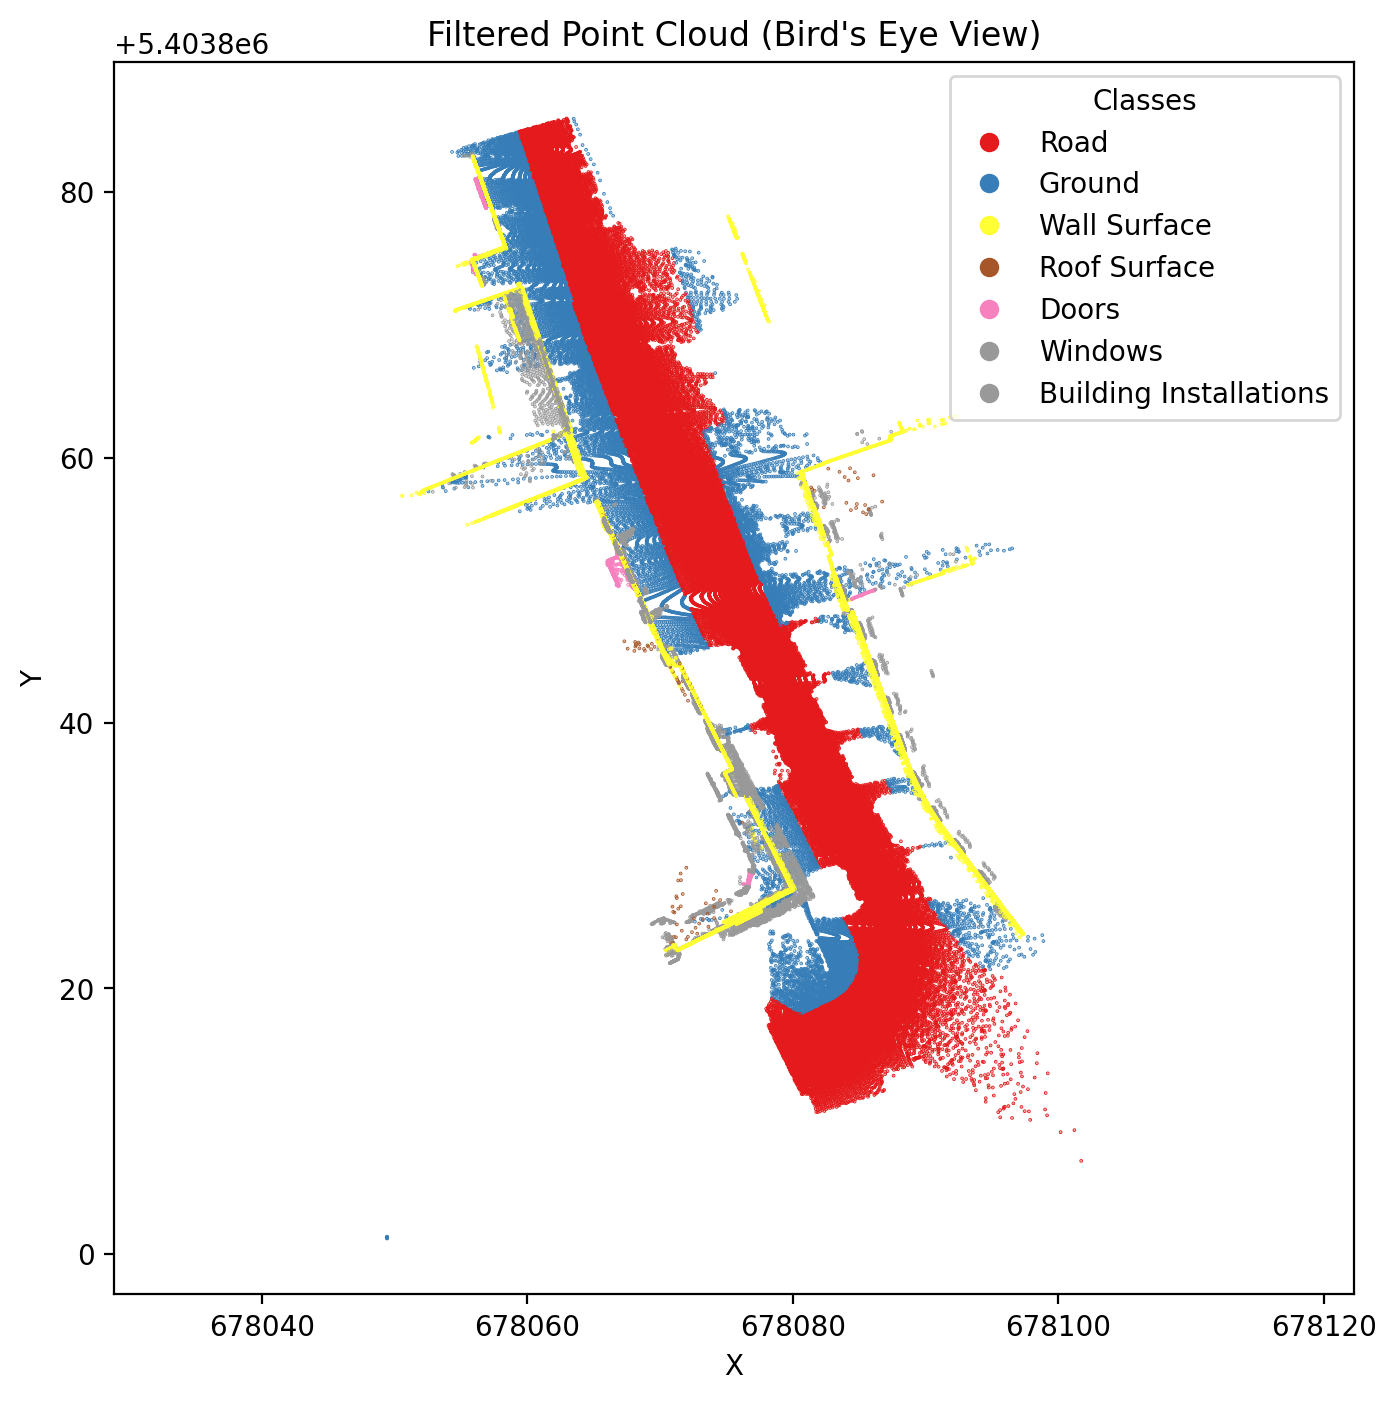

In [18]:
# plot cropped point clouds
helper.plot_bev(real_points_cropped, class_descriptions)

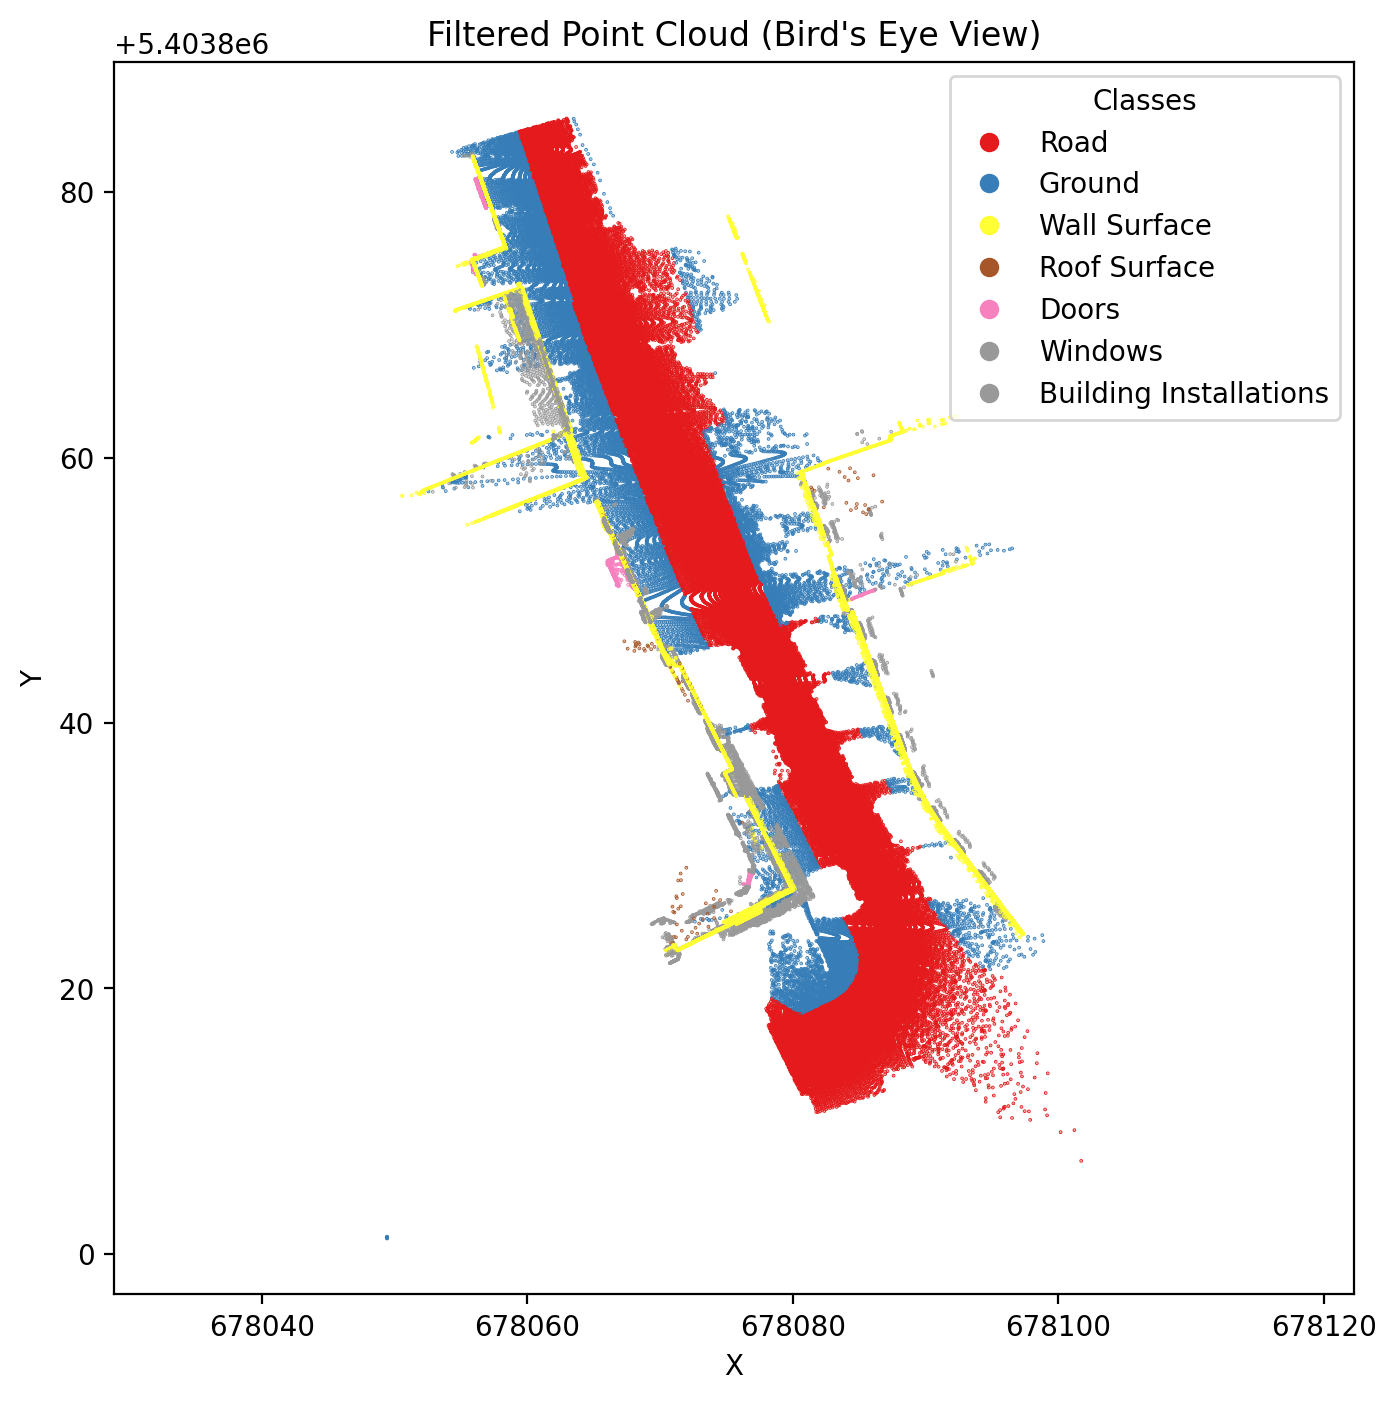

In [19]:
# plot cropped point clouds
helper.plot_bev(synth_points_cropped, class_descriptions)

#### Geometric Similarity (Haussdorff Distance)

In [20]:
# extract purely the coordinates of the points
real_xyz_cropped = real_points_cropped[['x', 'y', 'z']]
synth_xyz_cropped = synth_points_cropped[['x', 'y', 'z']]
# IDEA: do haussdorff distance only for each class/label

In [23]:
# TIME INTENSIVE/CRASHES KERNEL
#convex_hull_real = ConvexHull(real_xyz_cropped)

In [24]:
# TIME INTENSIVE/CRASHES KERNEL
#convex_hull_synth = ConvexHull(synth_xyz_cropped)

In [25]:
# TIME INTENSIVE/CRASHES KERNEL
# Compute the geometric difference between the aligned point clouds.
#haussdorff_distance = helper.hausdorff_distance(real_xyz_cropped, synth_xyz_cropped, convex_hull_real, convex_hull_synth)